<a href="https://colab.research.google.com/github/abbyambita/Diagnosing-COVID-from-CT-Scan-Images/blob/main/transfer_learning_with_acgan_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [14]:
import os 

os.chdir("/content/gdrive/My Drive")

!ls  '/content/gdrive/My Drive/CS 284 Mini-Project/Code/revised-kaggle-validation'

%cd "/content/gdrive/My Drive/CS 284 Mini-Project/Code"

test  train  val
/content/gdrive/.shortcut-targets-by-id/1eVFVz23F6ROX0s10Oe3tT9HVzr502iW2/CS 284 Mini-Project/Code


In [15]:
from __future__ import print_function, division

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import glob
import matplotlib.pyplot as plt
import torch
import time
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
from collections import OrderedDict
from torch.autograd import Variable
from PIL import Image
import PIL
from torch.optim import lr_scheduler
import copy
import json
import os
from os.path import exists

plt.ion()

In [16]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

nThreads = 4
batch_size = 32
use_gpu = torch.cuda.is_available()

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

cuda:0
CUDA is available!  Training on GPU ...


In [18]:
from sklearn.model_selection import train_test_split

import collections

In [19]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
                                 transforms.Resize((224, 224)),   
                                 transforms.CenterCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
    'val': transforms.Compose([
                                 transforms.Resize((224, 224)),                                       
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
    'test': transforms.Compose([
                                 transforms.Resize((224, 224)),                                       
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
}

data_dir = 'revised-kaggle-validation'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}

#load synthetic data
acgan_synthetic_dataset = datasets.ImageFolder(root='acgan_output_images/kaggle/batch_size=32_lr=0.001_epochs=600',transform = data_transforms['train'])
#print(len(acgan_synthetic_dataset))
#print(len(image_datasets['train']))

indices = np.arange(len(acgan_synthetic_dataset))
#add random_state later
train_indices, test_indices = train_test_split(indices, train_size=500*2, stratify=acgan_synthetic_dataset.targets)
train_dataset = torch.utils.data.Subset(acgan_synthetic_dataset, train_indices)
#train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, num_workers=2, batch_size=32)

dataset = torch.utils.data.ConcatDataset([image_datasets['train'], train_dataset])

dataloaders = {}
dataloaders['train'] = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)
dataloaders['val'] = torch.utils.data.DataLoader(image_datasets['val'], batch_size=32, shuffle=True, num_workers=4)
dataloaders['test'] = torch.utils.data.DataLoader(image_datasets['test'], batch_size=32, shuffle=True, num_workers=4)

dataset_sizes = {
    'train':len(dataset),
    'val': len(image_datasets['val']),
    'test': len(image_datasets['test'])
}
class_names = image_datasets['train'].classes

In [20]:
print(dataset_sizes)
print(class_names)

{'train': 4021, 'val': 365, 'test': 785}
['covid', 'noncovid']


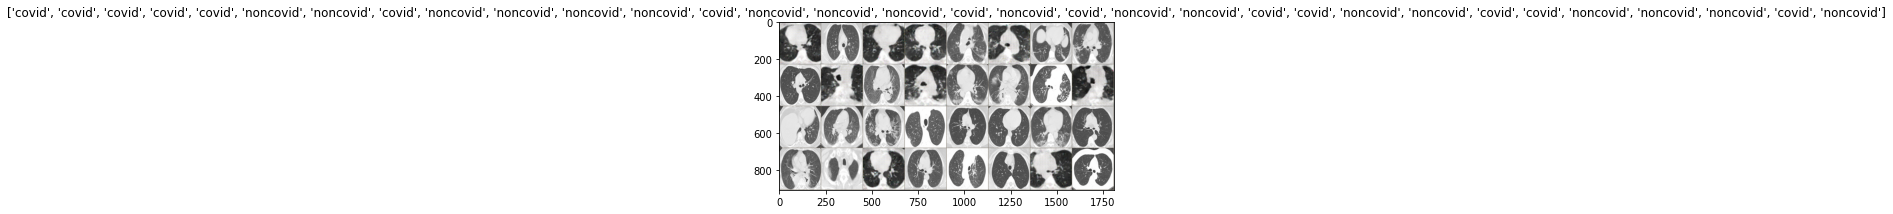

In [21]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [22]:
#remove scheduler

#def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
def train_model(model, criterion, optimizer, num_epochs=3):

    "Training begins..."


    train_losses = []
    test_losses = []
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                #scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'train':
              train_losses.append(epoch_loss)
            else:
              test_losses.append(epoch_loss)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, test_losses

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

def evaluate_performance(labels, preds, name, num_epochs):
  label = ['noncovid', 'covid']
  #print(confusion_matrix)
  conf_matrix = confusion_matrix(labels, preds)
  print(conf_matrix)

  # Per-class accuracy
  class_accuracy=100*conf_matrix.diagonal()/conf_matrix.sum(1)
  print(class_accuracy)

  print("Accuracy score:", accuracy_score(labels, preds))
  print(classification_report(labels, preds))

  report = classification_report(labels, preds, output_dict = True)
  df = pd.DataFrame(report).transpose()
  df.to_csv('model_result/acgan/kaggle/'+name+'_epochs_'+str(num_epochs)+'_classification_report.csv', index = False)


  plt.figure()
  plot_confusion_matrix(conf_matrix, classes=['NonCovid', 'Covid'],
                      title='Confusion matrix')
  plt.savefig('plots/acgan/kaggle/'+name+'_epochs_'+str(num_epochs)+'.png')
  plt.show()

In [24]:
# Do validation on the test set
def test(model, dataloaders, device, name, num_epochs):

  "Testing begins..."
  model.eval()
  accuracy = 0
  
  model.to(device)
  
  nb_classes = 2

  #confusion_matrix = torch.zeros(nb_classes, nb_classes)
  predlist = torch.zeros(0, dtype = torch.long, device = 'cpu')
  labellist = torch.zeros(0, dtype = torch.long, device = 'cpu')


  for images, labels in dataloaders['test']:
    images = Variable(images)
    labels = Variable(labels)
    images, labels = images.to(device), labels.to(device)
      
    output = model.forward(images)
    ps = torch.exp(output)
    equality = (labels.data == ps.max(1)[1])
    accuracy += equality.type_as(torch.FloatTensor()).mean()

    _, preds = torch.max(output, 1)
    # for t, p in zip(labels.view(-1), preds.view(-1)):
    #   confusion_matrix[t.long(), p.long()] += 1
    predlist=torch.cat([predlist,preds.view(-1).cpu()])
    labellist = torch.cat([labellist, labels.view(-1).cpu()])

    print("Testing Accuracy: {:.3f}".format(accuracy/len(dataloaders['test'])))

  evaluate_performance(labellist.numpy(), predlist.numpy(), name, num_epochs)

In [25]:
# Do validation on the test set (from another dataset)
def test_on_another_data(model, test_data, device, name, num_epochs):

  "Testing begins..."
  model.eval()
  accuracy = 0
  
  model.to(device)
  
  nb_classes = 2

  #confusion_matrix = torch.zeros(nb_classes, nb_classes)
  predlist = torch.zeros(0, dtype = torch.long, device = 'cpu')
  labellist = torch.zeros(0, dtype = torch.long, device = 'cpu')


  for images, labels in test_data:
    images = Variable(images)
    labels = Variable(labels)
    images, labels = images.to(device), labels.to(device)
      
    output = model.forward(images)
    ps = torch.exp(output)
    equality = (labels.data == ps.max(1)[1])
    accuracy += equality.type_as(torch.FloatTensor()).mean()

    _, preds = torch.max(output, 1)
    # for t, p in zip(labels.view(-1), preds.view(-1)):
    #   confusion_matrix[t.long(), p.long()] += 1
    predlist=torch.cat([predlist,preds.view(-1).cpu()])
    labellist = torch.cat([labellist, labels.view(-1).cpu()])

    print("Testing Accuracy: {:.3f}".format(accuracy/len(dataloaders['test'])))

  evaluate_performance(labellist.numpy(), predlist.numpy(), name, num_epochs)

<h1>Models</h1>

In [26]:
from collections import OrderedDict


# classifier = nn.Sequential(OrderedDict([
#     ('fcl1', nn.Linear(1024,256)),
#     ('dp1', nn.Dropout(0.3)),
#     ('r1', nn.ReLU()),
#     ('fcl2', nn.Linear(256,32)),
#     ('dp2', nn.Dropout(0.3)),
#     ('r2', nn.ReLU()),
#     ('fcl3', nn.Linear(32,2)),
#     #('out', nn.LogSoftmax(dim=1)),
# ]))

In [27]:
train_losses_all = []
test_losses_all = []

In [28]:
def run_model(model, name, freeze = False):
  # Freeze parameters so we don't backprop through them
  for param in model.parameters():
    param.requires_grad = freeze

  #model.classifier = classifier


  if use_gpu:
    print ("Using GPU: "+ str(use_gpu))
    model = model.cuda()
    
  # NLLLoss because our output is LogSoftmax
  #criterion = nn.NLLLoss()
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.0001)
  num_epochs = 50

  model_ft, train_losses, test_losses = train_model(model, criterion, optimizer, num_epochs=num_epochs)
  train_losses_all.append(train_losses)
  test_losses_all.append(test_losses)
  #model -> model_ft
  torch.save(model_ft, "model_backup/acgan/kaggle/"+name+"_epoch_"+str(num_epochs)+".pth")

  test(model_ft, dataloaders, device, name, num_epochs)
  plt.plot(train_losses, label='Training Loss')
  plt.plot(test_losses, label='Validation Loss')
  plt.legend(frameon=False)

  plt.savefig("plots/acgan/kaggle/"+name+"_epoch_"+str(num_epochs)+"_losses.png")


In [29]:
dir = "batch_size=32_lr=0.001_epochs=600_gen=500"
os.makedirs("plots/acgan/kaggle/"+dir, exist_ok=True)
os.makedirs("model_backup/acgan/kaggle/"+dir, exist_ok=True)
os.makedirs("model_result/acgan/kaggle/"+dir, exist_ok=True)

In [30]:
# model = models.vgg16(pretrained=True)
# model.classifier[6] = nn.Linear(4096,2)
# run_model(model, name = dir+"/vgg16",  freeze = True)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth



Using GPU: True
Epoch 1/50
----------
train Loss: 1.1344 Acc: 0.8093
val Loss: 0.2890 Acc: 0.8986

Epoch 2/50
----------
train Loss: 0.1139 Acc: 0.9580
val Loss: 0.3597 Acc: 0.8740

Epoch 3/50
----------
train Loss: 0.0877 Acc: 0.9684
val Loss: 0.4853 Acc: 0.8575

Epoch 4/50
----------
train Loss: 0.0680 Acc: 0.9781
val Loss: 0.1836 Acc: 0.9288

Epoch 5/50
----------
train Loss: 0.0276 Acc: 0.9908
val Loss: 0.4113 Acc: 0.8959

Epoch 6/50
----------
train Loss: 0.0421 Acc: 0.9861
val Loss: 0.6432 Acc: 0.8548

Epoch 7/50
----------
train Loss: 0.0353 Acc: 0.9888
val Loss: 0.3621 Acc: 0.9260

Epoch 8/50
----------
train Loss: 0.0419 Acc: 0.9861
val Loss: 0.3030 Acc: 0.9096

Epoch 9/50
----------
train Loss: 0.0579 Acc: 0.9821
val Loss: 0.2884 Acc: 0.9178

Epoch 10/50
----------
train Loss: 0.0272 Acc: 0.9905
val Loss: 0.2211 Acc: 0.9233

Epoch 11/50
----------
train Loss: 0.0439 Acc: 0.9843
val Loss: 0.2017 Acc: 0.9205

Epoch 12/50
----------
train Loss: 0.0185 Acc: 0.9943
val Loss: 0.18

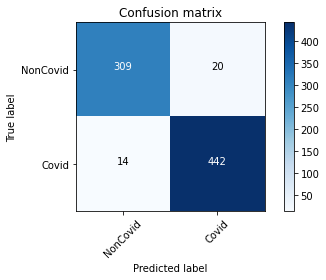

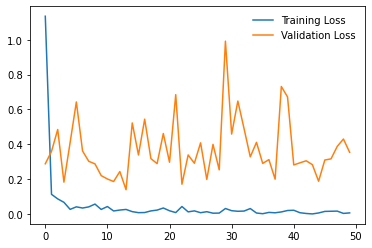

In [31]:
model = models.resnet101(pretrained=True)
model.classifier = nn.Linear(1024, 2)
run_model(model, name = dir+"/resnet101-v2",  freeze = True)

In [32]:
# model = models.resnet152(pretrained=True)
# model.classifier = nn.Linear(1024, 2)
# run_model(model, name = dir+"/resnet152",  freeze = True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



Using GPU: True
Epoch 1/50
----------
train Loss: 1.1322 Acc: 0.8185
val Loss: 0.4234 Acc: 0.8904

Epoch 2/50
----------
train Loss: 0.1199 Acc: 0.9555
val Loss: 0.2746 Acc: 0.9014

Epoch 3/50
----------
train Loss: 0.0797 Acc: 0.9712
val Loss: 0.8712 Acc: 0.8274

Epoch 4/50
----------
train Loss: 0.0877 Acc: 0.9724
val Loss: 0.5004 Acc: 0.8904

Epoch 5/50
----------
train Loss: 0.0336 Acc: 0.9896
val Loss: 0.3616 Acc: 0.9205

Epoch 6/50
----------
train Loss: 0.0357 Acc: 0.9866
val Loss: 0.5568 Acc: 0.8904

Epoch 7/50
----------
train Loss: 0.0462 Acc: 0.9848
val Loss: 0.3313 Acc: 0.9260

Epoch 8/50
----------
train Loss: 0.0321 Acc: 0.9881
val Loss: 0.2877 Acc: 0.9123

Epoch 9/50
----------
train Loss: 0.0383 Acc: 0.9878
val Loss: 0.2609 Acc: 0.9041

Epoch 10/50
----------
train Loss: 0.0225 Acc: 0.9925
val Loss: 0.2262 Acc: 0.9425

Epoch 11/50
----------
train Loss: 0.0144 Acc: 0.9950
val Loss: 0.2408 Acc: 0.9342

Epoch 12/50
----------
train Loss: 0.0249 Acc: 0.9915
val Loss: 0.47

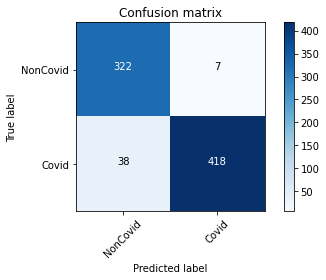

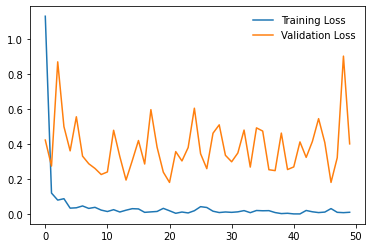

In [33]:
model = models.resnet50(pretrained=True)
model.classifier = nn.Linear(1024, 2)
run_model(model, name = dir+"/resnet50-v2",  freeze = True)

In [ ]:
model = models.resnet18(pretrained=True)
model.classifier = nn.Linear(1024, 2)
run_model(model, name = dir+"/resnet18-v2",  freeze = True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



Using GPU: True
Epoch 1/50
----------
train Loss: 1.7703 Acc: 0.7613
val Loss: 0.2461 Acc: 0.9397

Epoch 2/50
----------
train Loss: 0.1658 Acc: 0.9488
val Loss: 0.5523 Acc: 0.8603

Epoch 3/50
----------
train Loss: 0.0796 Acc: 0.9761
val Loss: 0.4362 Acc: 0.8740

Epoch 4/50
----------
train Loss: 0.0644 Acc: 0.9781
val Loss: 0.3637 Acc: 0.8877

Epoch 5/50
----------
train Loss: 0.0547 Acc: 0.9838
val Loss: 0.2408 Acc: 0.9233

Epoch 6/50
----------
train Loss: 0.0397 Acc: 0.9876
val Loss: 0.4186 Acc: 0.9014

Epoch 7/50
----------
train Loss: 0.0277 Acc: 0.9901
val Loss: 0.5296 Acc: 0.8822

Epoch 8/50
----------
train Loss: 0.0273 Acc: 0.9920
val Loss: 0.5663 Acc: 0.8959

Epoch 9/50
----------
train Loss: 0.0365 Acc: 0.9873
val Loss: 1.0484 Acc: 0.8795

Epoch 10/50
----------
train Loss: 0.0344 Acc: 0.9878
val Loss: 0.5765 Acc: 0.8630

Epoch 11/50
----------
train Loss: 0.0440 Acc: 0.9853
val Loss: 0.4837 Acc: 0.8904

Epoch 12/50
----------
train Loss: 0.0180 Acc: 0.9940
val Loss: 0.36

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth



Using GPU: True
Epoch 1/50
----------
train Loss: 0.2996 Acc: 0.8635
val Loss: 0.2540 Acc: 0.9096

Epoch 2/50
----------
train Loss: 0.1198 Acc: 0.9570
val Loss: 0.2162 Acc: 0.9205

Epoch 3/50
----------
train Loss: 0.0644 Acc: 0.9769
val Loss: 0.2657 Acc: 0.9096

Epoch 4/50
----------
train Loss: 0.0497 Acc: 0.9833
val Loss: 0.3569 Acc: 0.9178

Epoch 5/50
----------
train Loss: 0.0320 Acc: 0.9903
val Loss: 0.3372 Acc: 0.8767

Epoch 6/50
----------
train Loss: 0.0229 Acc: 0.9945
val Loss: 0.2765 Acc: 0.9233

Epoch 7/50
----------
train Loss: 0.0291 Acc: 0.9905
val Loss: 0.2551 Acc: 0.9397

Epoch 8/50
----------
train Loss: 0.0206 Acc: 0.9920
val Loss: 0.2726 Acc: 0.9370

Epoch 9/50
----------
train Loss: 0.0203 Acc: 0.9933
val Loss: 0.1886 Acc: 0.9397

Epoch 10/50
----------
train Loss: 0.0139 Acc: 0.9960
val Loss: 0.2220 Acc: 0.9397

Epoch 11/50
----------
train Loss: 0.0175 Acc: 0.9950
val Loss: 0.2527 Acc: 0.9479

Epoch 12/50
----------
train Loss: 0.0254 Acc: 0.9915
val Loss: 0.26

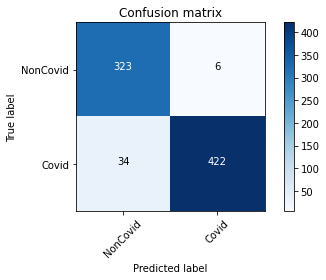

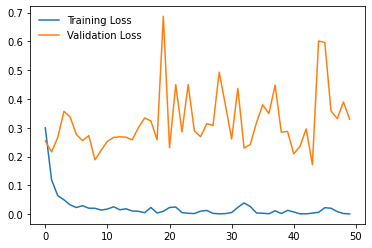

In [35]:
model = models.densenet121(pretrained=True)
model.classifier = nn.Linear(1024, 2)
run_model(model, name = dir+"/densenet121-v2",  freeze = True)

In [ ]:
class Swish(nn.Module):
    def forward(self, input_tensor):
        return input_tensor * torch.sigmoid(input_tensor)

from efficientnet_pytorch import EfficientNet

class EfficientNet_b0(nn.Module):
    def __init__(self):
        super(EfficientNet_b0, self).__init__()
        self.model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=2)
        
        self.layer10 = nn.Sequential(
            nn.BatchNorm1d(1280),
            nn.Dropout(0.8)
        )
        self.layer11a = nn.Sequential(
            nn.Linear(1280, 2048),
            nn.BatchNorm1d(2048),
            Swish(),
            nn.Dropout(0.8)
        )
        self.layer11b = nn.Sequential(
            nn.Linear(2048 , 1024),
            nn.BatchNorm1d(1024), 
            Swish(),
            nn.Dropout(0.8)
        )
        self.layer12 = nn.Sequential(
            nn.Linear(1024 , 512),
            nn.BatchNorm1d(512),
            Swish()
        )
        self.layer13 = nn.Sequential(
            nn.Linear(512 , 2),
            nn.Softmax()
        )
        
    def forward(self, inputs):
        x = self.model.extract_features(inputs)

        # Pooling and final linear layer
        x = self.model._avg_pooling(x)
        x = x.flatten(start_dim=1)
        x = self.model._dropout(x)
        x = self.layer10(x)
        x = self.layer11a(x)
        x = self.layer11b(x)
        x = self.layer12(x)
        x = self.layer13(x)
        return x

In [ ]:
model = EfficientNet_b0()
run_model(model, name = dir+"/ecn-b0",  freeze = True)

<h1>Plot All Losses</h1>

In [36]:
# def plot_all_losses(losses, t):
#     plt.figure()
#     models = ['Vgg16', 'Resnet101','Resnet152', 'ResNet50', 'ResNet18', 'DenseNet121']

#     for i, val in enumerate(losses):
#         plt.plot(val, label=models[i])
#         plt.legend(frameon=False)
#     plt.xlabel('epoch')
#     plt.ylabel('loss')
#     plt.title('Loss vs. No. of epochs')   
#     plt.savefig("plots/acgan/kaggle/"+dir+"/"+t+"_losses_resnet.png")
#     plt.show()
        
# plot_all_losses(train_losses_all, t="training")

In [37]:
# plot_all_losses(test_losses_all, t="testing")

<h1>Testing trained models on Sars_Cov_2 on CT_COVID dataset test set</h1>

In [38]:
# #densenet121_epoch_50.pth
# #resnet18_epoch_50.pth
# #resnet50_epoch_50.pth
# #resnet101_epoch_50.pth
# #resnet152_epoch_50.pth
# #vgg16_epoch_50.pth

# test_transform = transforms.Compose([
#                                  transforms.Resize((224, 224)),                                       
#                                  transforms.ToTensor(),
#                                  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
#     ])

# images_covid = "revised-kaggle-validation/"
# test_datasets = datasets.ImageFolder(os.path.join(images_covid, 'test'),transform= test_transform)

# test_loader = torch.utils.data.DataLoader(test_datasets, batch_size=32, shuffle=True, num_workers=4)

In [39]:
# run_model(model, name = dir+"/resnet101",  freeze = True)

In [40]:
# loaded_model = torch.load("model_backup/transfer_learning_results_kaggle/vgg16_epoch_50.pth")
# name = "vgg16_epoch_50_on_kaggle_trained_on_kaggle"
# test_on_another_data(loaded_model, test_loader, device, name, 50)

In [41]:
# loaded_model = torch.load("model_backup/transfer_learning_results_kaggle/resnet152_epoch_50.pth")
# name = "resnet152_epoch_50_on_kaggle_trained_on_kaggle"
# test_on_another_data(loaded_model, test_loader, device, name, 50)

In [42]:
# loaded_model = torch.load("model_backup/transfer_learning_results_kaggle/resnet101_epoch_50.pth")
# name = "resnet101_epoch_50_on_kaggle_trained_on_kaggle"
# test_on_another_data(loaded_model, test_loader, device, name, 50)

In [43]:
# loaded_model = torch.load("model_backup/transfer_learning_results_kaggle/resnet50_epoch_50.pth")
# name = "resnet50_epoch_50_on_kaggle_trained_on_kaggle"
# test_on_another_data(loaded_model, test_loader, device, name, 50)

In [44]:
# loaded_model = torch.load("model_backup/transfer_learning_results_kaggle/resnet18_epoch_50.pth")
# name = "resnet18_epoch_50_on_kaggle_trained_on_kaggle"
# test_on_another_data(loaded_model, test_loader, device, name, 50)

In [45]:
# loaded_model = torch.load("model_backup/transfer_learning_results_kaggle/resnet18_epoch_50.pth")
# name = "resnet18_epoch_50_on_kaggle_trained_on_kaggle"
# test_on_another_data(loaded_model, test_loader, device, name, 50)

In [46]:
# loaded_model = torch.load("model_backup/transfer_learning_results_kaggle/densenet121_epoch_50.pth")
# name = "densenet121_epoch_50_epoch_50_on_kaggle_trained_on_kaggle"
# test_on_another_data(loaded_model, test_loader, device, name, 50)